# CPSC 330 Lecture 10

#### Lecture plan

- Announcements
- Linear regression intro (5 min)
- Feature importances: linear regression (15 min)
- Exploring `alpha` (5 min)
- T/F questions (15 min)
- Break (5 min)
- Feature importances: beyond linear models (20 min)
- T/F questions (15 min)

In [2]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_blobs
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

New dependency: install with

```pip install shap```

or

```conda install -c conda-forge shap```

In [3]:
import shap

In [4]:
plt.rcParams['font.size'] = 16

In [5]:
def mape(true, pred):
    """
    Compute the Mean Absolute Percent Error (MAPE)
    given true target values and predictions.    
    """
    return 100.*np.mean(np.abs((pred - true)/true))

## Announcements

- hw4 released, due Sunday at 6pm.
- Midterm next week Thursday, Feb 13, at 11:05am in our usual classroom.
  - Midterm will cover material in lectures notebooks 1-8 and/or hw1-hw4.
  - Per [here](https://github.students.cs.ubc.ca/cpsc330-2019w-t2/home/blob/master/docs/course_info.md#midterm) you are allowed one double-sided sheet of notes.
  - See [this Piazza thread](https://piazza.com/class/k1gx4b3djbv3ph?cid=146) for some details on the midterm.
- There will likely be homework during Reading Week, due Sunday Feb 23.
  - I don't normally do this.
  - However, our homework is now significantly behind the lectures.
  - I really am sorry... 

## House price dataset

We'll repreat the processing from last class:

In [6]:
df_train = pd.read_csv("data/week_05_house-prices/train.csv")

In [7]:
df_train, df_test = train_test_split(df_train, test_size=0.1, random_state=123)

In [8]:
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=123)

In [9]:
target               = ['SalePrice']
drop_features        = ['Id']
numeric_features     = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                        'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(df_train.columns) - set(target) - set(drop_features) - 
                            set(numeric_features) - 
                            set(ordinal_features_reg) - set(ordinal_features_oth))
all_features = numeric_features + ordinal_features_reg + categorical_features + ordinal_features_oth

ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex'] # if N/A it will just impute something, per below

In [10]:
imputers = [
    ('numeric', SimpleImputer(strategy='median'), numeric_features),
    ('ordinal', SimpleImputer(strategy='most_frequent'), ordinal_features_reg),
    ('categor', SimpleImputer(strategy='constant', fill_value="?"), 
     categorical_features + ordinal_features_oth)]
# NOTE: the order here must match the order of all_features

In [11]:
impute_transformer = ColumnTransformer(transformers=imputers)

In [12]:
impute_transformer.fit(df_train);

In [13]:
df_train_imp = pd.DataFrame(impute_transformer.transform(df_train), index=df_train.index, columns=all_features)
df_valid_imp = pd.DataFrame(impute_transformer.transform(df_valid), index=df_valid.index, columns=all_features)
df_test_imp  = pd.DataFrame(impute_transformer.transform(df_test),  index=df_test.index,  columns=all_features)

In [14]:
feature_transformers = [
    ('scale',  StandardScaler(), numeric_features),
    ('ord',    OrdinalEncoder(categories=[ordering for i in ordinal_features_reg]), ordinal_features_reg),
    # note changes           VVVVVVVVVV       and     VVVVVVVVVVVVVVVVVVVVVVV
    ('ohe',    OneHotEncoder(drop=None, sparse=False, handle_unknown='ignore'), categorical_features + ordinal_features_oth)]

In [15]:
feature_preprocessor = ColumnTransformer(transformers=feature_transformers)

In [16]:
feature_preprocessor.fit(df_train_imp);

In [17]:
new_columns = numeric_features + ordinal_features_reg + list(feature_preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features + ordinal_features_oth))
new_columns;

In [18]:
X_train_imp_encode = feature_preprocessor.transform(df_train_imp)
X_valid_imp_encode = feature_preprocessor.transform(df_valid_imp)
X_test_imp_encode  = feature_preprocessor.transform(df_test_imp)

df_train_imp_encode = pd.DataFrame(X_train_imp_encode, index=df_train_imp.index, columns=new_columns)
df_valid_imp_encode = pd.DataFrame(X_valid_imp_encode, index=df_valid_imp.index, columns=new_columns)
df_test_imp_encode  = pd.DataFrame(X_test_imp_encode,  index=df_test_imp.index,  columns=new_columns)

In [19]:
y_train = df_train["SalePrice"]
y_valid = df_valid["SalePrice"]
y_test  = df_test["SalePrice"]

In [20]:
y_train_log = np.log(y_train)
y_valid_log = np.log(y_valid)
y_test_log  = np.log(y_test)

## Linear regression intro (5 min)

- Linear regression is one of the most basic and popular ML/statistical techniques. 
- We already saw logistic regression for classification - these are close cousins.
- Both are very _interpretable_.
- For more depth, see CPSC 340, STAT 306, and various other STAT courses.
- In scikit-learn, we can do:

In [21]:
LinearRegression();

However, I am going to recommend always using:

In [22]:
Ridge();

- `Ridge` is more flexible than `LinearRegression` because it has a hyperparameter `alpha`:

In [23]:
lr_vanilla = LinearRegression()
lr_vanilla.fit(X_train_imp_encode, y_train);

In [24]:
lr_vanilla_preds = lr_vanilla.predict(X_valid_imp_encode)
lr_vanilla_preds[:10]

array([3.12866250e+05, 1.65690250e+05, 1.32112250e+05, 1.36061250e+05,
       1.53357250e+05, 9.48637500e+04, 2.17124250e+05, 8.76913733e+14,
       8.95000000e+04, 1.77312750e+05])

In [25]:
lr_vanilla_preds.max()

876913733284065.8

In [26]:
lr_vanilla_preds.min()

-904039234422046.8

- One prediction is for $\$10^{15}$ !!
- One prediction is for $ - \$10^{15}$ !!!!
- This happened because we have "collinear features" and there are "numerical issues" (see also CPSC 302).
- `Ridge` "solves" this issue:

In [27]:
lr = Ridge()
lr.fit(X_train_imp_encode, y_train);

In [28]:
lr.predict(X_valid_imp_encode)[:10]

array([320510.32157338, 173556.58421713, 152063.03386156, 141280.47236704,
       150721.65449548, 107631.90531937, 223663.19498538, 100382.53283966,
        70586.83522943, 189271.9364687 ])

- `Ridge` has a hyperparameter `alpha`.
- This is like `C` in `LogisticRegression` but, annoyingly, `alpha` is the _inverse_ of `C`.
  - That is, large `C` is like small `alpha` and vice versa.
- We can (approximately) recover the original `LinearRegression` by setting `alpha=0` (but I don't recommend this).
- TL;DR don't use `LinearRegression`
  - Unless you know what you're doing, but then use [statsmodels](https://www.statsmodels.org/stable/index.html) or R instead of sklearn. 

Let's compare with the random forest:

In [29]:
lr = Ridge()
lr.fit(X_train_imp_encode, y_train_log);

In [30]:
print("Training MAPE: %.1f%%" % mape(y_train, np.exp(lr.predict(X_train_imp_encode))))

Training MAPE: 7.1%


In [31]:
print("Validation MAPE: %.1f%%" % mape(y_valid, np.exp(lr.predict(X_valid_imp_encode))))

Validation MAPE: 9.5%


In [32]:
rf = RandomForestRegressor(random_state=111)
rf.fit(X_train_imp_encode, np.log(y_train));

In [33]:
print("Training MAPE: %.1f%%" % mape(y_train, np.exp(rf.predict(X_train_imp_encode))))

Training MAPE: 3.7%


In [34]:
print("Validation MAPE: %.1f%%" % mape(y_valid, np.exp(rf.predict(X_valid_imp_encode))))

Validation MAPE: 10.6%


- So far, the linear model seems to be doing better. 
- Note that it's also a _simpler_ model.
- Like logistic regression, the intuition is that "the complexity grows as you add more features". 

## Feature importances: linear regression (15 min)

- Like logistic regression, with linear regression we can look at the _coefficients_ for each feature.
- Overall idea: predicted price = intercept + $\sum_i$ coefficient i $\times$ feature i.
- Let's first train on the un-logged data, for simplicity:

In [35]:
lr = Ridge()
lr.fit(X_train_imp_encode, y_train);

In [36]:
lr_coefs = pd.DataFrame(data=lr.coef_, index=df_train_imp_encode.columns, columns=["Coefficient"])
lr_coefs.head(30)

Coefficient
LotFrontage    -2186.562754
LotArea         5245.619061
OverallQual    13686.897467
OverallCond     4726.199691
YearBuilt       1777.145405
YearRemodAdd    -408.563972
MasVnrArea      4683.880369
BsmtFinSF1      3138.711804
BsmtFinSF2       514.420585
BsmtUnfSF      -2102.343962
TotalBsmtSF     1367.384174
1stFlrSF        7134.437042
2ndFlrSF       13632.049729
LowQualFinSF    -886.833398
GrLivArea      16361.413390
BsmtFullBath    2087.077801
BsmtHalfBath     705.992590
FullBath        2831.933925
HalfBath        2286.419691
TotRmsAbvGrd    4915.403586
Fireplaces      3128.969036
GarageYrBlt     -857.042521
GarageCars      9446.132015
GarageArea     -1774.997061
WoodDeckSF      1873.733901
OpenPorchSF      180.823083
EnclosedPorch   -513.761240
3SsnPorch       1768.923349
ScreenPorch     2173.598240
PoolArea        3371.421029

In [37]:
lr.intercept_

-96074.8340093139

Intuition: 

- **Increasing** `PoolArea` by 1 scaled unit **increases** the predicted price by $\sim\$3400$.
- **Increasing** `LotFrontage` by 1 scaled unit **decreases** the predicted price by $\sim\$2200$.

Does that seem reasonable?

- For `PoolArea`, yes. 
- For `LotFrontage`, that's surprising.
- Do we believe these interpretations??
  - Do we believe this is how the predictions are being computed? Yes.
  - Do we believe that this is how the world works? No. 
  - For more info, take STAT 306.

BTW, let's make sure this interpretation is true:

In [38]:
one_example = X_valid_imp_encode[:1]

In [39]:
lr.predict(one_example)

array([320510.32157338])

In [40]:
one_example_perturbed = one_example.copy()
one_example_perturbed[0,0] += 1 # add 1 to the LotFrontage

In [41]:
lr.predict(one_example_perturbed)

array([318323.7588191])

In [42]:
lr.predict(one_example_perturbed) - lr.predict(one_example)

array([-2186.56275428])

- Let's have a look at the sorted list of coefficients:

In [43]:
lr_coefs.sort_values(by="Coefficient")

Coefficient
RoofMatl_ClyTile     -174307.016789
Condition2_PosN      -102693.648005
BedroomAbvGr_5        -21523.847732
Condition1_RRAe       -20762.820804
Neighborhood_Edwards  -19681.706418
...                             ...
PoolQC                 33608.674121
Condition2_PosA        34268.025292
Neighborhood_NridgHt   39408.648618
Neighborhood_StoneBr   51841.282699
RoofMatl_WdShngl      118347.614850

[288 rows x 1 columns]

- What about units? `PoolArea` is in sqft, so does that mean $\$3000/\text{sqft}$? 

<br><br><br>

- No! We scaled the features.

In [44]:
scaler = feature_preprocessor.named_transformers_['scale']

- The scaler subtracted the mean and divided by the standard deviation.
- For the unit conversion, we don't care about the subtraction, but only the scaling.

In [45]:
np.sqrt(scaler.var_)

array([2.14683300e+01, 9.63462880e+03, 1.42413369e+00, 1.09904111e+00,
       2.97737968e+01, 2.07131774e+01, 1.84575195e+02, 4.70844011e+02,
       1.69751213e+02, 4.46030656e+02, 4.58874197e+02, 4.06604427e+02,
       4.30768683e+02, 4.21979265e+01, 5.33922776e+02, 5.16385274e-01,
       2.30186116e-01, 5.46413339e-01, 4.99568663e-01, 1.61098085e+00,
       6.35200462e-01, 2.36726184e+01, 7.49175078e-01, 2.15332348e+02,
       1.23911370e+02, 6.38913250e+01, 5.92775787e+01, 3.09876358e+01,
       5.63942754e+01, 4.72942137e+01, 5.81539330e+02, 1.34047839e+00])

In [46]:
lr_scales = pd.DataFrame(data=np.sqrt(scaler.var_), index=numeric_features, columns=["Scale"])
lr_scales

Scale
LotFrontage      21.468330
LotArea        9634.628804
OverallQual       1.424134
OverallCond       1.099041
YearBuilt        29.773797
YearRemodAdd     20.713177
MasVnrArea      184.575195
BsmtFinSF1      470.844011
BsmtFinSF2      169.751213
BsmtUnfSF       446.030656
TotalBsmtSF     458.874197
1stFlrSF        406.604427
2ndFlrSF        430.768683
LowQualFinSF     42.197926
GrLivArea       533.922776
BsmtFullBath      0.516385
BsmtHalfBath      0.230186
FullBath          0.546413
HalfBath          0.499569
TotRmsAbvGrd      1.610981
Fireplaces        0.635200
GarageYrBlt      23.672618
GarageCars        0.749175
GarageArea      215.332348
WoodDeckSF      123.911370
OpenPorchSF      63.891325
EnclosedPorch    59.277579
3SsnPorch        30.987636
ScreenPorch      56.394275
PoolArea         47.294214
MiscVal         581.539330
YrSold            1.340478

- It seems like `PoolArea` was divided by 47 sqft. 
- So $\$3400/\text{unit} \times \frac{1 \text{unit}}{47 \text{sqft}} \approx \$70/\text{sqft}$

In [47]:
lr_coefs.loc["PoolArea","Coefficient"]/lr_scales.loc["PoolArea","Scale"]

71.28612071539546

- That makes a bit more sense!
  - (But, again, don't read too much into this number without statistical training!)
- Note: we can get the same result using the scaler's `inverse_transform` function:

In [48]:
delta = scaler.inverse_transform(np.ones(len(numeric_features))) - scaler.inverse_transform(np.zeros(len(numeric_features)))
lr_scales2 = pd.DataFrame(data=delta, index=numeric_features, columns=["Scale"])
lr_scales2

Scale
LotFrontage      21.468330
LotArea        9634.628804
OverallQual       1.424134
OverallCond       1.099041
YearBuilt        29.773797
YearRemodAdd     20.713177
MasVnrArea      184.575195
BsmtFinSF1      470.844011
BsmtFinSF2      169.751213
BsmtUnfSF       446.030656
TotalBsmtSF     458.874197
1stFlrSF        406.604427
2ndFlrSF        430.768683
LowQualFinSF     42.197926
GrLivArea       533.922776
BsmtFullBath      0.516385
BsmtHalfBath      0.230186
FullBath          0.546413
HalfBath          0.499569
TotRmsAbvGrd      1.610981
Fireplaces        0.635200
GarageYrBlt      23.672618
GarageCars        0.749175
GarageArea      215.332348
WoodDeckSF      123.911370
OpenPorchSF      63.891325
EnclosedPorch    59.277579
3SsnPorch        30.987636
ScreenPorch      56.394275
PoolArea         47.294214
MiscVal         581.539330
YrSold            1.340478

- Actually `inverse_transform` is nicer in a way, because it generalized to any sort of scaler/normalizer you're using.

- What about the categorical features?
- We didn't scale these, so we can interpret the coefficients without this concern.
- The ordinal features are easiest:

In [49]:
ordinal_features_reg

['ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PoolQC']

In [50]:
lr_coefs.loc["ExterQual", 'Coefficient']

2140.9308294263988

- "Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by \\$2140".

- The OHE features are a bit more of a hassle.

In [51]:
categorical_features

['Condition2',
 'MSSubClass',
 'Heating',
 'Foundation',
 'MSZoning',
 'MiscFeature',
 'Street',
 'MasVnrType',
 'Neighborhood',
 'MoSold',
 'Condition1',
 'LotConfig',
 'LandSlope',
 'Electrical',
 'PavedDrive',
 'Utilities',
 'RoofStyle',
 'RoofMatl',
 'SaleCondition',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'LandContour',
 'BldgType',
 'Exterior1st',
 'SaleType',
 'Exterior2nd',
 'GarageFinish',
 'GarageType',
 'Alley',
 'CentralAir',
 'HouseStyle',
 'LotShape']

In [52]:
lr_coefs_landslope = lr_coefs[lr_coefs.index.str.startswith("LandSlope")]
lr_coefs_landslope

Coefficient
LandSlope_Gtl   -41.313220
LandSlope_Mod  6071.762489
LandSlope_Sev -6030.449270

- We can talk about switching from one of these categories to another by picking a "reference" category:

In [53]:
lr_coefs_landslope - lr_coefs_landslope.loc["LandSlope_Gtl"]

Coefficient
LandSlope_Gtl     0.000000
LandSlope_Mod  6113.075709
LandSlope_Sev -5989.136050

- So, going from a gentle slope to a moderate slope would increase the predicted price by \\$6113.
- And going from a gentle slope to a severe slope would decrease the predicted price by \\$5989.

Be a bit careful here:

- If you did `drop='first'` (we didn't) then you already have a reference class, and all the values are with respect to that one.

- The interpretation depends on whether we did `drop='first'`, hence the hassle.
- Here, we did not. 

In [54]:
lr_coefs.sort_values(by="Coefficient")

Coefficient
RoofMatl_ClyTile     -174307.016789
Condition2_PosN      -102693.648005
BedroomAbvGr_5        -21523.847732
Condition1_RRAe       -20762.820804
Neighborhood_Edwards  -19681.706418
...                             ...
PoolQC                 33608.674121
Condition2_PosA        34268.025292
Neighborhood_NridgHt   39408.648618
Neighborhood_StoneBr   51841.282699
RoofMatl_WdShngl      118347.614850

[288 rows x 1 columns]

- "If the roof is made of clay or tile, the predicted price is \\$174k less" ?
- It would have been easier to interpret had we used `drop='first'` because then we'd have a reference. 

#### Interpretation in log space

- As mentioned last class, if we log-transform the targets then the interpretation changes.

In [55]:
lr_log = Ridge()
lr_log.fit(X_train_imp_encode, y_train_log);

In [56]:
lr_log_coefs = pd.DataFrame(data=lr_log.coef_, index=df_train_imp_encode.columns, columns=["Coefficient"])
lr_log_coefs.head(30)

Coefficient
LotFrontage      -0.005665
LotArea           0.015757
OverallQual       0.066756
OverallCond       0.036968
YearBuilt         0.038590
YearRemodAdd      0.004109
MasVnrArea        0.004485
BsmtFinSF1        0.003414
BsmtFinSF2        0.008255
BsmtUnfSF        -0.008999
TotalBsmtSF      -0.002190
1stFlrSF          0.051211
2ndFlrSF          0.030747
LowQualFinSF      0.001329
GrLivArea         0.063911
BsmtFullBath      0.016424
BsmtHalfBath      0.002672
FullBath          0.017325
HalfBath          0.016464
TotRmsAbvGrd      0.017776
Fireplaces        0.021775
GarageYrBlt      -0.007375
GarageCars        0.039060
GarageArea        0.006954
WoodDeckSF        0.015300
OpenPorchSF       0.006651
EnclosedPorch     0.006851
3SsnPorch         0.009022
ScreenPorch       0.016932
PoolArea          0.002889

- We keep the intuition that positive coefficients make the predicted price go up, negative coefficients make it go down.
- If we increase `PoolArea` by 1, then we increase the **log** predicted price by 0.003.
- What does it mean to increase the log of something by $x$?

log(new) = log(old) + $x$

Take exp of both sides:

new = old  $\times \exp(x)$

So, increasing `PoolArea` by 1 means we _multiply_ the predicted price by

In [57]:
np.exp(lr_log_coefs.loc["PoolArea", "Coefficient"])

1.0028931043770528

And, increasing `LotFrontage` by 1 means we _multiply_ the predicted price by

In [58]:
np.exp(lr_log_coefs.loc["LotFrontage", "Coefficient"])

0.9943512217771416

(Advanced note) For those familiar with Taylor expansions, you will know that when $x$ is small then $\exp(x)\approx 1+x$, which is what you're seeing here. But in general we might have big coefficients and this approximation is not helpful to think about.

Let's test this out!

In [59]:
one_example = X_valid_imp_encode[:1]

In [60]:
np.exp(lr_log.predict(one_example))

array([327891.95111023])

In [61]:
one_example_perturbed = one_example.copy()
one_example_perturbed[0,0] += 1 # add 1 to the LotFrontage

In [62]:
np.exp(lr_log.predict(one_example_perturbed))

array([326039.76219735])

In [63]:
np.exp(lr_log.predict(one_example_perturbed)) / np.exp(lr_log.predict(one_example))

array([0.99435122])

- So we can say something like, "Increasing the pool area by 47 sq ft causes the predicted price to go up by around 0.3%".
- Again, I am being careful to say "predicted price" instead of price, because we're just talking about our model, not the world.

## Exploring `alpha` (5 min)

- The `alpha` hyperparameter controls the fundamental tradeoff as usual.
  - Smaller `alpha`: lower training error.
  - Larger `alpha`: lower approximation error (hopefully). 
- General intuition: larger `alpha` leads to **smaller coefficients**. 
  - Smaller coefficients mean the predictions are less sensitive to changes in the data.
  - Hence less chance of overfitting (seeing big dependencies when you shouldn't).
- Let's test this out:

In [64]:
lr = Ridge(alpha=0.01)
lr.fit(X_train_imp_encode, y_train_log);
np.max(np.abs(lr.coef_))

2.1840738424511157

In [65]:
lr = Ridge(alpha=1)
lr.fit(X_train_imp_encode, y_train_log);
np.max(np.abs(lr.coef_))

0.6348741804662522

In [66]:
lr = Ridge(alpha=1000)
lr.fit(X_train_imp_encode, y_train_log);
np.max(np.abs(lr.coef_))

0.051110092371153715

- Note that it will not make all the coefficients smaller in the same proportion!
- The order of the coefficients might change. 

In [67]:
lr = Ridge(alpha=0.01)
lr.fit(X_train_imp_encode, y_train_log);
df_train_imp_encode.columns[np.argmax(np.abs(lr.coef_))]

'RoofMatl_ClyTile'

In [68]:
lr = Ridge(alpha=1)
lr.fit(X_train_imp_encode, y_train_log);
df_train_imp_encode.columns[np.argmax(np.abs(lr.coef_))]

'RoofMatl_ClyTile'

In [69]:
lr = Ridge(alpha=100)
lr.fit(X_train_imp_encode, y_train_log);
df_train_imp_encode.columns[np.argmax(np.abs(lr.coef_))]

'OverallQual'

Let's try tuning `alpha`:

In [70]:
alphas = 10.0**np.arange(-1.5,4.5,0.5)
train_errs = []
valid_errs = []
for alpha in alphas:

    lr = Ridge(alpha=alpha)
    lr.fit(X_train_imp_encode, y_train_log);
    train_errs.append(mape(y_train, np.exp(lr.predict(X_train_imp_encode))))
    valid_errs.append(mape(y_valid, np.exp(lr.predict(X_valid_imp_encode))))

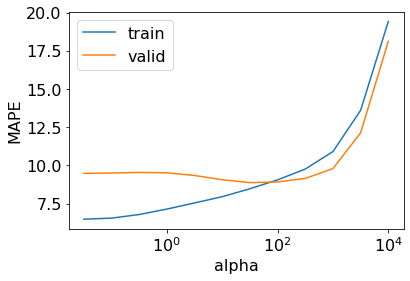

In [71]:
plt.semilogx(alphas, train_errs, label="train");
plt.semilogx(alphas, valid_errs, label="valid");
plt.legend();
plt.xlabel('alpha');
plt.ylabel('MAPE');

In [72]:
best_alpha = alphas[np.argmin(valid_errs)]
best_alpha

31.622776601683793

In [73]:
train_errs = []
valid_errs = []
for alpha in alphas:

    lr = Ridge(alpha=alpha)
    lr.fit(X_train_imp_encode, y_train);
    train_errs.append(np.sqrt(mean_squared_error(y_train, lr.predict(X_train_imp_encode))))
    valid_errs.append(np.sqrt(mean_squared_error(y_valid, lr.predict(X_valid_imp_encode))))

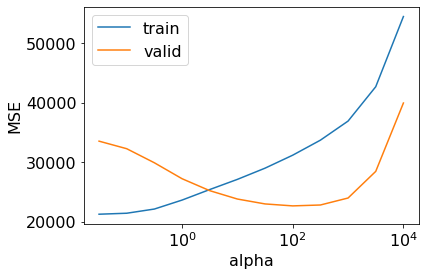

In [74]:
plt.semilogx(alphas, train_errs, label="train");
plt.semilogx(alphas, valid_errs, label="valid");
plt.legend();
plt.xlabel('alpha');
plt.ylabel('MSE');

In [75]:
best_alpha = alphas[np.argmin(valid_errs)]
best_alpha

100.0

- These are interesting curves, because the validation error is less than the training error.
- In short, that is because when `alpha` is large we are no longer directly minimizing training error.
- It seems `alpha=100` is the best choice here. 

In [76]:
lr = Ridge(alpha=100)
lr.fit(X_train_imp_encode, y_train_log);

In [77]:
print("Training MAPE: %.1f%%" % mape(y_train, np.exp(lr.predict(X_train_imp_encode))))

Training MAPE: 9.1%


In [78]:
print("Validation MAPE: %.1f%%" % mape(y_valid, np.exp(lr.predict(X_valid_imp_encode))))

Validation MAPE: 8.9%


- I'm sure one could do a lot better on this dataset, but 9% MAPE is a start!

## Linear regression True/False (15 min)

1. When you call `fit`, linear regression learns one coefficient per feature.
2. If the first coefficient is 5, that means increasing your first feature by 1 increases the prediction by 5.
3. log-transforming the targets (and re-fitting) is equivalent to log-transforming the coefficients. 
4. Since the `PoolArea` has a positive coefficient, expanding my pool will get me a higher price when I sell my house.
5. Larger values of `alpha` are probably more useful when I have lots of features.

## Break (5 min)

## Feature importances: beyond linear models (20 min)

#### Why model interpretability? 

- Ability to interpret ML models is crucial in many applications such as banking, healthcare, and criminal justice.
- It can be leveraged by domain experts to diagnose systematic errors and underlying biases of complex ML systems. 
- One problem is that often simple models are interpretable but not accurate.
  - (The previous example, where `Ridge` performed well, notwithstanding!)
- But more complex models, like random forests, are less interpretable.
- However, some modern tools can help us interpret feature importances for these models.
- There is more to interpretability than feature importances, but it's a good start!

#### Model interpretability 

- We will be looking at two ways for model interpretability. 
    - sklearn `feature_importances_`
    - [SHAP](https://github.com/slundberg/shap)

In [79]:
rf = RandomForestRegressor(random_state=111)
rf.fit(X_train_imp_encode, np.log(y_train));

In [80]:
rf.feature_importances_;

In [81]:
rf_importances = pd.DataFrame(data=rf.feature_importances_, index=df_train_imp_encode.columns, columns=["Importance"])
rf_importances.sort_values(by="Importance")

Importance
MiscFeature_TenC  0.000000e+00
Condition2_PosA   0.000000e+00
KitchenAbvGr_3    0.000000e+00
Utilities_AllPub  0.000000e+00
Condition2_RRAe   3.782311e-09
...                        ...
BsmtFinSF1        2.525542e-02
1stFlrSF          2.539890e-02
TotalBsmtSF       4.267111e-02
GrLivArea         9.596270e-02
OverallQual       5.930921e-01

[288 rows x 1 columns]

- Unlike the linear model coefficients, `feature_importances_` do not have a sign!
  - They tell us about importance, but not an "up or down".
  - Indeed, increasing a feature may cause the prediction to first go up, and then go down.
  - This cannot happen in linear models, because they are linear.
- We could compare with the absolute value of the coefficients from Ridge:

In [82]:
lr_tuned_log = Ridge(alpha=100)
lr_tuned_log.fit(X_train_imp_encode, np.log(y_train));

In [83]:
lr_tuned_log_coefs = pd.DataFrame(data=lr_tuned_log.coef_, index=df_train_imp_encode.columns, columns=["Coefficient"])
lr_tuned_log_coefs.abs().sort_values(by="Coefficient")

Coefficient
Exterior1st_ImStucc     0.000172
MiscFeature_Gar2        0.000177
MSSubClass_85           0.000179
Condition2_Artery       0.000203
MasVnrType_?            0.000204
...                          ...
BsmtQual                0.033383
OverallCond             0.039747
GrLivArea               0.041132
GarageCars              0.043084
OverallQual             0.084340

[288 rows x 1 columns]

- Both models agree that overall quality is by far the most important feature (makes sense!).
- Note: we should not be comparing the actual numbers, e.g. 0.59 from random forest vs. 0.08 from linear regression.

- These values tell us globally about which features are importants.
- But what if you want to explain a _specific_ prediction. 
- Some fancier tools can help us do this.

#### SHAP  (SHapley Additive exPlanations)

- A sophisticated measure of the contribution of each feature.
- For more detail, see [GitHub repo](https://github.com/slundberg/shap) and [paper](https://arxiv.org/pdf/1705.07874.pdf).
- We won't go in details. You may refer to  if you are interested to know more. 

In [84]:
explainer = shap.TreeExplainer(rf)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


We'll compute the SHAP values on the training set (but could do it for other data):

In [85]:
X_train_imp_encode.shape

(1051, 288)

In [86]:
shap_values = explainer.shap_values(X_train_imp_encode) # Warning: takes a long time

This is just a numpy array:

In [87]:
shap_values.shape

(1051, 288)

In [88]:
X_train_imp_encode.shape

(1051, 288)

In [89]:
shap.initjs()

In [90]:
df_train_imp_encode.head(1)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
1341    -0.165978  0.338699    -0.062802    -0.505587   1.048406   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  \
1341      0.927764   -0.577947    0.791412   -0.284437  -0.622612  ...   

      Functional_Maj2  Functional_Min1  Functional_Min2  Functional_Mod  \
1341              0.0              0.0              0.0             0.0   

      Functional_Typ  Fence_?  Fence_GdPrv  Fence_GdWo  Fence_MnPrv  \
1341             1.0      1.0          0.0         0.0          0.0   

      Fence_MnWw  
1341         0.0  

[1 rows x 288 columns]

In [91]:
rf.predict(X_train_imp_encode)[0]

11.939096301012096

In [92]:
shap.force_plot(explainer.expected_value, shap_values[0], df_train_imp_encode.iloc[0])

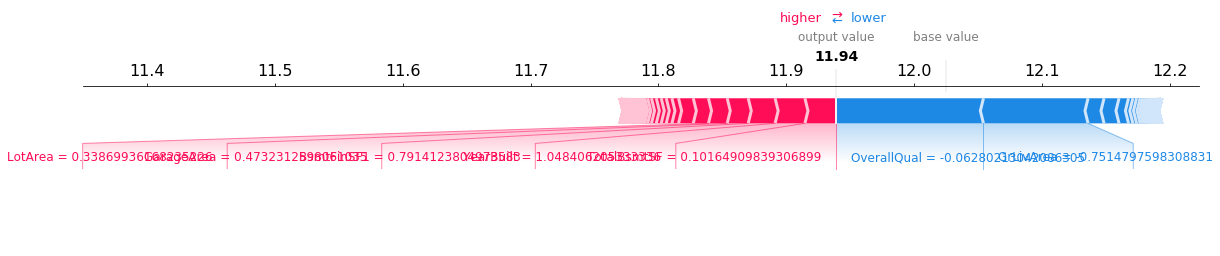

In [93]:
shap.force_plot(explainer.expected_value, shap_values[0], df_train_imp_encode.iloc[0], matplotlib=True)

Above: for this particular training example, we can see the main factors pushing it from the base value (average over the dataset) to this particular prediction. 

Note: a nice thing about SHAP values is that the feature importances sum to the prediction:

In [100]:
rf.predict(X_train_imp_encode)[0]

11.939096301012096

In [102]:
X_train_imp_encode.shape

(1051, 288)

In [105]:
shap_values[0].sum() + explainer.expected_value

11.93909630101211

This is the case for classification as well, but for the "raw model output" rather than the probability itself, because the SHAP values do not necessarily sum to something between 0 and 1.

In [94]:
# shap.force_plot(explainer.expected_value, shap_values[:100], df_train_imp_encode.iloc[:100])

In [95]:
# shap.force_plot(explainer.expected_value, shap_values[:100], df_train_imp_encode.iloc[:100], matplotlib=True)

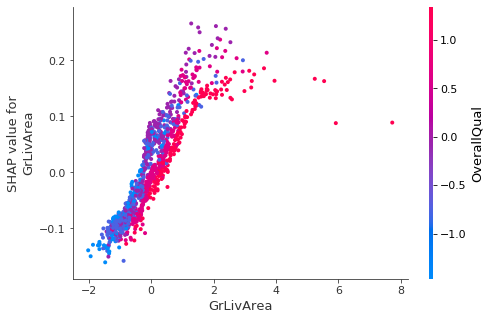

In [96]:
shap.dependence_plot("GrLivArea", shap_values, df_train_imp_encode)

- When `GrLivArea` (above grade living area) is increase, the shap value also increases -> that makes sense.
- But this type of plot also allows us to visualize non-linear or even non-monotonic behaviours.
- Note: shap automatically selects another feature -- in this case `OverallQual` -- for colouring.

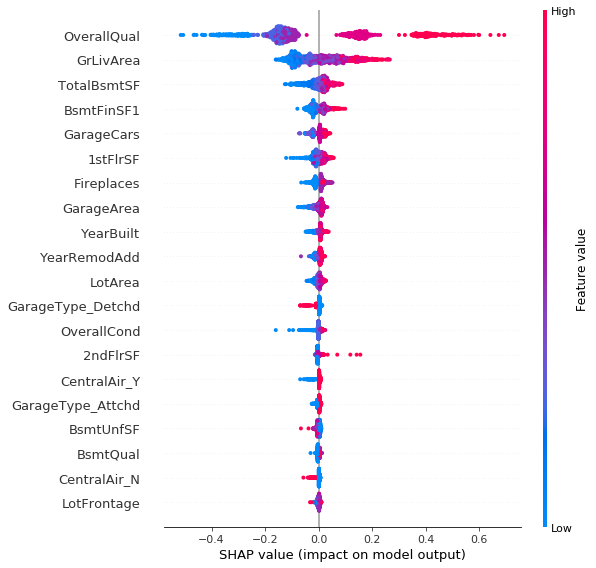

In [97]:
shap.summary_plot(shap_values, df_train_imp_encode)

- This plot orders features by importance (average SHAP value magnitude).
- Each example is drawn.
- We can see again that the prediction is higher when `OverallQual` is higher.
- There's also a summary of the summary:

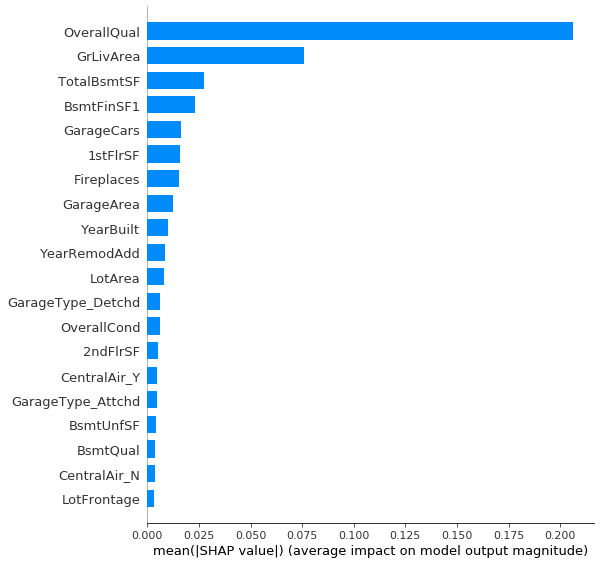

In [98]:
shap.summary_plot(shap_values, df_train_imp_encode, plot_type="bar")

Going back to the `feature_importances_`, we see something similar:

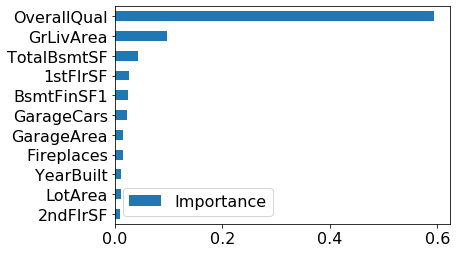

In [99]:
rf_importances.sort_values(by="Importance", ascending=False)[10::-1].plot.barh();

(Note: pandas has some built-in rudimentary plotting functionalities, which are quite convenient at times.) 

#### Other tools

- [ELI5](https://github.com/TeamHG-Memex/eli5) is another related package.
- [lime](https://github.com/marcotcr/lime) is yet another.

If you're not already impressed, keep in mind:

- So far we've only used sklearn models.
- Most sklearn models have some built-in measure of feature importances.
- On many tasks we need to move beyond sklearn, e.g. LightGBM, deep learning.
  - Not sure yet how much of that we'll do in this course.
- These tools work on other models as well, which makes them extremely useful.

#### Why do we want this information?

Possible reasons:

- Identify features that are not useful and maybe remove them.
- Get guidance on what new data to collect.
  - New features related to useful features -> better results.
  - Don't bother collecting useless features -> save resources.
- Help explain why the model is making certain predictions. 
  - Debugging, if the model is behaving strangely.
  - Regulatory requirements.
  - Fairness / bias.
- And more...

## Feature importances True/False (15 min)

1. With linear models, increasing a feature value always impacts the prediction in the same direction; with other models, this may not be the case.
2. scikit-learn's feature importances only pertain to the training data. 
3. SHAP values only pertain to the training data.
4. Based on the plot below, newer houses tend to cost more than older houses.
5. Based on the plot below, age is less important for higher quality houses than for lower quality houses.  

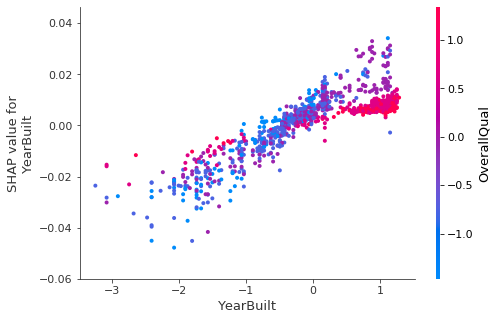

In [101]:
shap.dependence_plot("YearBuilt", shap_values, df_train_imp_encode)